<a href="https://colab.research.google.com/github/GeorgeShmelin/Masterschool_time_series_Project_supermarket_favorita/blob/main/3_part_time_series_LSTM_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import joblib
from tensorflow.keras.models import load_model

In [ ]:
import gc # gc.collect() are for rubbish collection

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV # new import we need for this week



---
# Data download


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_download = pd.read_csv('/content/drive/MyDrive/MasterSchool/MasterSchool_Python/Time_Series/Time_series_project/df_train_3.csv')
df_download.shape

(26307, 24)

This data has been already joined, encoded (mostly by One Hot Encoder) and filtered. Full path of the data download, cleaning and encoding using SQL is presented in https://github.com/GeorgeShmelin/MasterSchool_Python_Studies.git or https://colab.research.google.com/drive/1rxXgcs68TGxuIKV8dAk3dWDCgaQSfNbQ?usp=sharing

In [ ]:
# Downcast numeric columns to smallest possible types
for col in df_download.select_dtypes(include=['int', 'float']).columns:
    if pd.api.types.is_integer_dtype(df_download[col]):
        df_download[col] = pd.to_numeric(df_download[col], downcast='integer')
    elif pd.api.types.is_float_dtype(df_download[col]):
        df_download[col] = pd.to_numeric(df_download[col], downcast='float')
        df_download[col] = pd.to_numeric(df_download[col], downcast='float')

In [ ]:
# Convert 'date' column to datetime if it's not already
df_download['date'] = pd.to_datetime(df_download['date'])

# Recreate related columns to ensure they are correctly derived
df_download['month'] = df_download['date'].dt.month.astype('int8')
df_download['day'] = df_download['date'].dt.day.astype('int8')
df_download['week'] = df_download['date'].dt.isocalendar().week.astype('int8')
df_download['day_of_week'] = df_download['date'].dt.dayofweek.astype('int8')  # 0 = Monday, 6 = Sunday

In [ ]:
df_download['year'] = df_download['date'].dt.year # year_scaled column
df_download['year_scaled'] = (df_download['year'] - df_download['year'].min()) / (df_download['year'].max() - df_download['year'].min())
df_download['year'] = df_download['year'].astype('category')

In [ ]:
df_download['weighted_unit_sales'] = df_download['weighted_unit_sales'].round(2)
df_download['unit_sales'] = df_download['unit_sales'].round(2)
df_download['dcoilwtico'] = df_download['dcoilwtico'].round(2)

In [ ]:
del df_download['year']
del df_download['date']

In [ ]:
df_download['store_nbr'] = df_download['store_nbr'].astype('category')
df_download['item_nbr'] = df_download['item_nbr'].astype('category')
df_download['item_class'] = df_download['item_class'].astype('category')

In [ ]:
df_download.sample(3)

,unit_sales,store_nbr,item_nbr,onpromotion,dcoilwtico,transferred,item_class,transactions,weighted_unit_sales,month,...,year_scaled,city_Daule,city_Guayaquil,city_Libertad,city_Playas,city_nan,items_family_BEVERAGES,items_family_CLEANING,items_family_GROCERY I,items_family_nan
20330,3.0,26,211205,0,46.060001,0,1072,695,3.0,1,...,1.0,0,1,0,0,0,0,0,1,0
23428,1.0,35,812735,0,49.950001,0,1004,669,1.0,2,...,1.0,0,0,0,1,0,0,0,1,0
2020,4.0,51,413987,0,99.809998,0,3034,2055,4.0,5,...,0.0,0,1,0,0,0,0,1,0,0


In [ ]:
df_download.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26307 entries, 0 to 26306
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   unit_sales              26307 non-null  float32 
 1   store_nbr               26307 non-null  category
 2   item_nbr                26307 non-null  category
 3   onpromotion             26307 non-null  int8    
 4   dcoilwtico              26307 non-null  float32 
 5   transferred             26307 non-null  int8    
 6   item_class              26307 non-null  category
 7   transactions            26307 non-null  int16   
 8   weighted_unit_sales     26307 non-null  float32 
 9   month                   26307 non-null  int8    
 10  day                     26307 non-null  int8    
 11  week                    26307 non-null  int8    
 12  day_of_week             26307 non-null  int8    
 13  year_scaled             26307 non-null  float64 
 14  city_Daule            

In [ ]:
gc.collect() # rubbish collection

0

## data preprocessing

Here I am going to transfer my data to a data which in my view best fit for LSTM application - avoid any object/categorical data, also scale all possible data points which may confuse my model

In [ ]:
df_f = df_download.copy() # for filtering

In [ ]:
del df_f['store_nbr']
del df_f['item_nbr']
del df_f['item_class']

For LSTM model I should avoid any object or categorical data in order not to confuse my model - therefore because it is quite a lot of points to transfer it by One Hot Encoding, thus I will delete it here

In [ ]:
df_f.shape

(26307, 20)

In [ ]:
# Initialize the scaler
scaler = MinMaxScaler()

 inverse transform to get the original scale

In [ ]:
# y_pred_original = target_scaler.inverse_transform(y_pred_scaled)

In [ ]:
# Fit and transform my columns
df_f['unit_sales_sc'] = scaler.fit_transform(df_f[['unit_sales']])
del df_f['unit_sales']

df_f['weighted_unit_sales_sc'] = scaler.fit_transform(df_f[['weighted_unit_sales']])
del df_f['weighted_unit_sales']

df_f['dcoilwtico_sc'] = scaler.fit_transform(df_f[['dcoilwtico']])
del df_f['dcoilwtico']

df_f['transactions_sc'] = scaler.fit_transform(df_f[['transactions']])
del df_f['transactions']

Cyclical Feature Transformation Code

In [ ]:
#columns: 'day', 'week', 'month', 'day_of_week'

# Day of year (1–365 or 366)
df_f['day_sin'] = np.sin(2 * np.pi * df_f['day'] / 365)
df_f['day_cos'] = np.cos(2 * np.pi * df_f['day'] / 365)

# Week of year (1–52)
df_f['week_sin'] = np.sin(2 * np.pi * df_f['week'] / 52)
df_f['week_cos'] = np.cos(2 * np.pi * df_f['week'] / 52)

# Month (1–12)
df_f['month_sin'] = np.sin(2 * np.pi * df_f['month'] / 12)
df_f['month_cos'] = np.cos(2 * np.pi * df_f['month'] / 12)

# Day of week (0–6, where 0=Monday)
df_f['dow_sin'] = np.sin(2 * np.pi * df_f['day_of_week'] / 7)
df_f['dow_cos'] = np.cos(2 * np.pi * df_f['day_of_week'] / 7)

df_f = df_f.drop(columns=['day', 'week', 'month', 'day_of_week'])

In [ ]:
df_f.sample(3)

,onpromotion,transferred,year_scaled,city_Daule,city_Guayaquil,city_Libertad,city_Playas,city_nan,items_family_BEVERAGES,items_family_CLEANING,...,dcoilwtico_sc,transactions_sc,day_sin,day_cos,week_sin,week_cos,month_sin,month_cos,dow_sin,dow_cos
1691,0,0,0.0,0,0,0,1,0,0,0,...,0.894362,0.095026,0.463550,0.886071,0.822984,-0.568065,8.660254e-01,-5.000000e-01,0.000000,1.000000
19607,0,0,0.0,0,1,0,0,0,0,0,...,0.155824,0.515466,0.508671,0.860961,0.120537,0.992709,-2.449294e-16,1.000000e+00,0.974928,-0.222521
23922,0,0,1.0,0,1,0,0,0,1,0,...,0.109046,0.436526,0.017213,0.999852,0.885456,0.464723,1.000000e+00,6.123234e-17,-0.781831,0.623490


Random Validation Split (for LSTM)

In [ ]:
# keep 20% for validation
train_df, val_df = train_test_split(df_f, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
gc.collect() # rubbish collection

0

# Model

###  Step 1: Prepare Data for LSTM Input

LSTM needs input shaped as (samples, time_steps, features).

👇 Define a function to create sequences:

In [ ]:
def create_sequences(data, target_col, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length].drop(columns=[target_col]).values)
        y.append(data.iloc[i+sequence_length][target_col])
    return np.array(X), np.array(y)

In [ ]:
sequence_length = 7  # or any time window
X_train, y_train = create_sequences(train_df, 'transactions_sc', sequence_length)
X_val, y_val = create_sequences(val_df, 'transactions_sc', sequence_length)

### Step 2: Build LSTM Model with Keras

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_model(input_shape, lstm_units=64, dropout_rate=0.2):
    model = Sequential([
        LSTM(units=lstm_units, input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(1)  # regression output
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

### Step 3: Save Best Model (Checkpoint)

In [ ]:
checkpoint = ModelCheckpoint(
    'best_lstm_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

### Step 4: Train the Model

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0369
Epoch 1: val_loss improved from inf to 0.03026, saving model to best_lstm_model.h5


658/658 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0369 - val_loss: 0.0303
Epoch 2/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0304
Epoch 2: val_loss improved from 0.03026 to 0.02961, saving model to best_lstm_model.h5


658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0304 - val_loss: 0.0296
Epoch 3/100
652/658 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0305
Epoch 3: val_loss improved from 0.02961 to 0.02961, saving model to best_lstm_model.h5


658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0305 - val_loss: 0.0296
Epoch 4/100
653/658 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0301
Epoch 4: val_loss did not improve from 0.02961
658/658 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0301 - val_loss: 0.0297
Epoch 5/100
656/658 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0297
Epoch 5: val_loss improved from 0.02961 to 0.02958, saving model to best_lstm_model.h5


658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0297 - val_loss: 0.0296
Epoch 6/100
656/658 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0295
Epoch 6: val_loss improved from 0.02958 to 0.02953, saving model to best_lstm_model.h5


658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0295 - val_loss: 0.0295
Epoch 7/100
656/658 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0293
Epoch 7: val_loss did not improve from 0.02953
658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0293 - val_loss: 0.0295
Epoch 8/100
651/658 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0297
Epoch 8: val_loss did not improve from 0.02953
658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0297 - val_loss: 0.0297
Epoch 9/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0295
Epoch 9: val_loss did not improve from 0.02953
658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0295 - val_loss: 0.0296
Epoch 10/100
655/658 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0295
Epoch 10: val_loss improved from 0.02953 to 0.02949, saving model to best_lstm_model.h5


658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0295 - val_loss: 0.0295
Epoch 11/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0295
Epoch 11: val_loss did not improve from 0.02949
658/658 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0295 - val_loss: 0.0297
Epoch 12/100
656/658 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0293
Epoch 12: val_loss did not improve from 0.02949
658/658 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0293 - val_loss: 0.0296
Epoch 13/100
650/658 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0296
Epoch 13: val_loss did not improve from 0.02949
658/658 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0296 - val_loss: 0.0296
Epoch 14/100
652/658 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0290
Epoch 14: val_loss did not improve from 0.02949
658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0290 - val_loss: 0.0295
Epoch 15/100
651/658 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0292
Epoch 15: val_loss did not improve from 0.02949
658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/st

### Step 5: Evaluate Model with R² on Validation

first need to predict on the validation set, and then compute R² using sklearn.metrics

In [ ]:
# Predict using the trained model
y_val_pred = model.predict(X_val)

# Compute R² score
r2 = r2_score(y_val, y_val_pred)

print(f"R² on validation data: {r2:.4f}")

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
R² on validation data: -0.0027


Optional: Inverse transform the predictions (if needed)

If y_val and y_val_pred are in scaled form, and you want to evaluate R² on original values, do:

In [ ]:
# Inverse transform if you scaled 'transactions' originally
y_val_orig = scaler.inverse_transform(y_val.reshape(-1, 1))
y_val_pred_orig = scaler.inverse_transform(y_val_pred)

r2_orig = r2_score(y_val_orig, y_val_pred_orig)
print(f"R² on original scale: {r2_orig:.4f}")

R² on original scale: -0.0027


### Plot LSTM Predictions vs Real Values

1. Make predictions

In [ ]:
y_val_pred = model.predict(X_val)

# Optionally inverse transform using the 'scaler' object (assuming 'transactions' was scaled with it)
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_val_pred)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2. Align with actual dates

Assuming val_df contains a date column (or something similar):

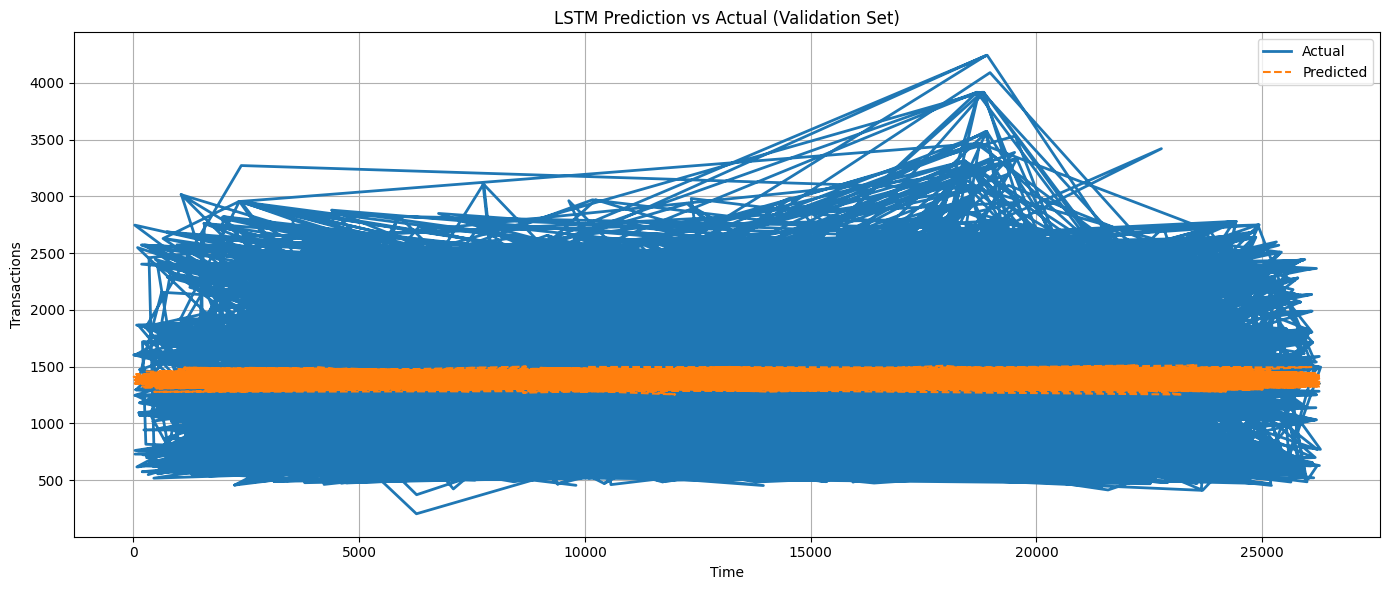

In [ ]:
# Get corresponding dates (shift by sequence_length)
val_dates = val_df.iloc[sequence_length:].index  # or .date if you have a datetime column

# Plot
plt.figure(figsize=(14, 6))
plt.plot(val_dates, y_val_inv, label='Actual', linewidth=2)
plt.plot(val_dates, y_pred_inv, label='Predicted', linestyle='--')
plt.title('LSTM Prediction vs Actual (Validation Set)')
plt.xlabel('Time')
plt.ylabel('Transactions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
gc.collect() # rubbish collection

4752

## Save my Model to Google Drive

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')

Create a folder (optional)
# import os

model_path = '/content/drive/MyDrive/MasterSchool/MasterSchool_Python/Time_Series/Time_series_project/xgboost_models'
os.makedirs(model_path, exist_ok=True)
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\nCreate a folder (optional)\n# import os\n\nmodel_path = '/content/drive/MyDrive/MasterSchool/MasterSchool_Python/Time_Series/Time_series_project/xgboost_models'\nos.makedirs(model_path, exist_ok=True)\n"

Save the trained model

In [ ]:
model_path = '/content/drive/MyDrive/MasterSchool/MasterSchool_Python/Time_Series/Time_series_project/xgboost_models'

In [ ]:
# import joblib
joblib.dump(model, model_path + '/lstm_final_model.h5')

['/content/drive/MyDrive/MasterSchool/MasterSchool_Python/Time_Series/Time_series_project/xgboost_models/lstm_final_model.h5']

## Use of the Saved Model

for the model test I am going to use another dates of the same "Favorita" data

In [ ]:
df_test_download = pd.read_csv('/content/drive/MyDrive/MasterSchool/MasterSchool_Python/Time_Series/Time_series_project/df_train_2.csv')

In [ ]:
df_test = df_test_download.copy()
df_test.shape

(56271, 25)

In [ ]:
df_test['date'] = pd.to_datetime(df_test['date'])
print("Min date:", df_test['date'].min())
print("Max date:", df_test['date'].max())
# based on my previous data research - that exactly time period was stable (in terms of shopping), therefore I will use all the data

Min date: 2016-09-15 00:00:00
Max date: 2017-01-04 00:00:00


In [ ]:
del df_test['holiday_type']
del df_test['locale']

now apply all the transformations applied in my train data

In [ ]:
del df_test['store_nbr']
del df_test['store_cluster']
del df_test['item_nbr']

In [ ]:
# Fit and transform my columns
df_test['unit_sales_sc'] = scaler.fit_transform(df_test[['unit_sales']])
del df_test['unit_sales']

df_test['weighted_unit_sales_sc'] = scaler.fit_transform(df_test[['weighted_unit_sales']])
del df_test['weighted_unit_sales']

df_test['dcoilwtico_sc'] = scaler.fit_transform(df_test[['dcoilwtico']])
del df_test['dcoilwtico']

df_test['transactions_sc'] = scaler.fit_transform(df_test[['transactions']])
del df_test['transactions']

In [ ]:
# Cyclical Feature Transformation Code

# Day of year (1–365 or 366)
df_test['day_sin'] = np.sin(2 * np.pi * df_test['date'].dt.day / 365)
df_test['day_cos'] = np.cos(2 * np.pi * df_test['date'].dt.day / 365)

# Week of year (1–52)
df_test['week_sin'] = np.sin(2 * np.pi * df_test['date'].dt.isocalendar().week / 52)
df_test['week_cos'] = np.cos(2 * np.pi * df_test['date'].dt.isocalendar().week / 52)

# Month (1–12)
df_test['month_sin'] = np.sin(2 * np.pi * df_test['date'].dt.month / 12)
df_test['month_cos'] = np.cos(2 * np.pi * df_test['date'].dt.month / 12)

# Day of week (0–6, where 0=Monday)
df_test['dow_sin'] = np.sin(2 * np.pi * df_test['date'].dt.dayofweek / 7)
df_test['dow_cos'] = np.cos(2 * np.pi * df_test['date'].dt.dayofweek / 7)

In [ ]:
df_test = df_test.drop(columns=['date'])

In [ ]:
df_test.sample(2)

,onpromotion,transferred,month,month_day,week,items_family_BEVERAGES,items_family_GROCERY I,items_family_PRODUCE,items_family_nan,year_scaled,...,dcoilwtico_sc,transactions_sc,day_sin,day_cos,week_sin,week_cos,month_sin,month_cos,dow_sin,dow_cos
23154,0,0,11,2,44,0,1,0,0,-1,...,0.207840,0.150019,0.034422,0.999407,-0.822984,0.568065,-0.5,0.866025,0.974928,-0.222521
27936,0,0,11,15,46,0,1,0,0,-1,...,0.257065,0.178612,0.255353,0.966848,-0.663123,0.748511,-0.5,0.866025,0.781831,0.623490


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56271 entries, 0 to 56270
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   onpromotion             56271 non-null  int64  
 1   transferred             56271 non-null  int64  
 2   month                   56271 non-null  int64  
 3   month_day               56271 non-null  int64  
 4   week                    56271 non-null  int64  
 5   items_family_BEVERAGES  56271 non-null  int64  
 6   items_family_GROCERY I  56271 non-null  int64  
 7   items_family_PRODUCE    56271 non-null  int64  
 8   items_family_nan        56271 non-null  int64  
 9   year_scaled             56271 non-null  int64  
 10  city_Daule              56271 non-null  int64  
 11  city_Guayaquil          56271 non-null  int64  
 12  city_Libertad           56271 non-null  int64  
 13  city_Playas             56271 non-null  int64  
 14  city_nan                56271 non-null

### Step 1: Load the model

In [ ]:
model_path = '/content/drive/MyDrive/MasterSchool/MasterSchool_Python/Time_Series/Time_series_project/xgboost_models/lstm_final_model.h5'  # Add the filename
model = joblib.load(model_path) # Now joblib.load() should find the pickle file

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Step 2: Create sequences from df_test

Use the same sequence_length you used in training (e.g., 7)

In [ ]:
sequence_length = 7  # Must match training

Assuming my test set is identical in structure and has transactions_sc as the scaled target column

In [ ]:
X_test, y_test = create_sequences(df_test, 'transactions_sc', sequence_length)

### Step 3: Make predictions

In [ ]:
# Before creating sequences for testing, convert all relevant columns in df_test to numeric types.
for col in df_test.columns:
    if df_test[col].dtype == 'object':
        try:
            df_test[col] = pd.to_numeric(df_test[col])
        except ValueError:
            # Handle columns that can't be directly converted to numeric (e.g., using encoding)
            print(f"Column '{col}' could not be converted to numeric.")

### Step 4: Inverse transform (optional, if scaled)

my scaled transactions with a MinMaxScaler called target_scaler:

In [ ]:
# Before creating sequences for testing, ensure all columns are numeric
for col in df_test.columns:
    if df_test[col].dtype == 'object':
        try:
            df_test[col] = pd.to_numeric(df_test[col])
        except ValueError:
            # If conversion fails, fill with a suitable value (e.g., 0) or apply encoding
            df_test[col] = df_test[col].astype('category').cat.codes
            # Apply category codes instead of filling with 0 to handle categorical data
    # Additional check for non-numeric types after conversion (e.g., category)
    if not pd.api.types.is_numeric_dtype(df_test[col]):
        df_test[col] = df_test[col].astype(int)  # Convert to int if still not numeric

# Now create sequences
X_test, y_test = create_sequences(df_test, 'transactions_sc', sequence_length)

In [ ]:
# Before creating sequences for testing, ensure all columns are numeric
for col in df_test.columns:
    if not pd.api.types.is_numeric_dtype(df_test[col]):
        try:
            # Convert to numeric if possible
            df_test[col] = pd.to_numeric(df_test[col])
        except ValueError:
            # If not numeric, handle by replacing non-numeric values with a placeholder (e.g., -1) and convert to numeric
            df_test[col] = pd.to_numeric(df_test[col], errors='coerce').fillna(-1)

# Now create sequences
X_test, y_test = create_sequences(df_test, 'transactions_sc', sequence_length)